##### Copyright 2018 The TensorFlow Authors.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from tensorflow import keras
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization
from PIL import Image
import time

seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [ ]:
# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 5000 # 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 50 # 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def train_val_split(caption_data, train_valid_split=0.6, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_valid_split (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_valid_split)

    # 4. Split into validation and testing sets
    valid_size = int(len(caption_data) * (1 - train_valid_split) / 2)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size: train_size + valid_size]
    }

    testing_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size + valid_size:]
    }

    # 4. Return the splits
    return training_data, validation_data, testing_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data, testing_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))
print("Number of testing samples: ", len(testing_data))

Number of training samples:  4680
Number of validation samples:  1560
Number of testing samples:  1561


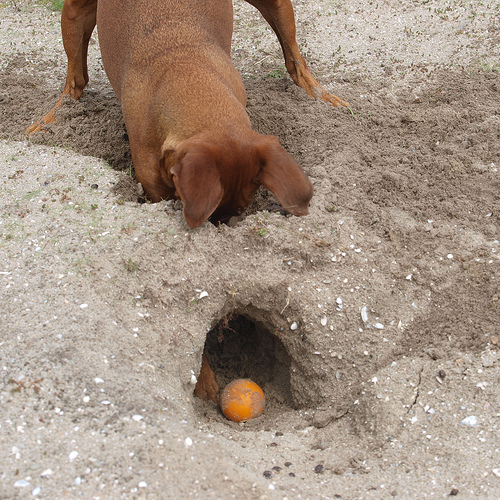

In [ ]:
# load image
import random

images = list(train_data.keys())
img_path = images[random.randint(0, len(images))]
Image.open(img_path)

In [ ]:
train_data[img_path]

['<start> A brown dog digging for a ball in the sand <end>',
 '<start> A brown dog digs in the sand for an orange ball . <end>',
 '<start> A brown dog is trying to retrive his orange ball that has fallen in a dirt hole . <end>',
 '<start> A dog burrowing in the dirt trying to get an orange ball . <end>',
 '<start> A dog digging for his ball in the sand . <end>']

In [ ]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
# image_augmentation = keras.Sequential(
#     [
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(0.2),
#         layers.RandomContrast(0.3),
#     ]
# )

In [ ]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=vectorization.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=vectorization.get_vocabulary(),
    invert=True)

In [ ]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(len(images))
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

test_dataset = make_dataset(list(testing_data.keys()), list(testing_data.values()))

In [ ]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 50), dtype=tf.int64, name=None))>

In [ ]:
valid_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 50), dtype=tf.int64, name=None))>

In [ ]:
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 50), dtype=tf.int64, name=None))>

## InceptionV3 as Encoder

In [ ]:
def get_cnn_model():
    image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
    # We freeze our feature extractor
    image_model.trainable = False
    base_model_out = image_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(image_model.input, base_model_out)
    return cnn_model

Positional Encoding

In [ ]:
def get_angles(pos, i, d_model):
   angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
   return pos * angle_rates

def positional_encoding_1d(position, d_model):
   angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)

   angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
   angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
   pos_encoding = angle_rads[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32)

def positional_encoding_2d(row,col,d_model):
   assert d_model % 2 == 0
   row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
   col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)

   angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
   angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

   angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
   angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
   angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
   angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
   pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [ ]:
def create_padding_mask(seq):
   seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
   return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
   mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
   return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
   matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
   dk = tf.cast(tf.shape(k)[-1], tf.float32)
   scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

   if mask is not None:
      scaled_attention_logits += (mask * -1e9) 

   attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
   output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

   return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads):
      super(MultiHeadAttention, self).__init__()
      self.num_heads = num_heads
      self.d_model = d_model
      assert d_model % self.num_heads == 0
      self.depth = d_model // self.num_heads
      self.wq = tf.keras.layers.Dense(d_model)
      self.wk = tf.keras.layers.Dense(d_model)
      self.wv = tf.keras.layers.Dense(d_model)
      self.dense = tf.keras.layers.Dense(d_model)

   def split_heads(self, x, batch_size):
      x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
      return tf.transpose(x, perm=[0, 2, 1, 3])

   def call(self, v, k, q, mask=None):
      batch_size = tf.shape(q)[0]
      q = self.wq(q)  # (batch_size, seq_len, d_model)
      k = self.wk(k)  # (batch_size, seq_len, d_model)
      v = self.wv(v)  # (batch_size, seq_len, d_model)

      q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
      k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
      v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

      scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
      scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

      concat_attention = tf.reshape(scaled_attention,
                                 (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

      output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
      return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
   return tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                tf.keras.layers.Dense(d_model)])  # (batch_size, seq_len, d_model)])

Encoder-Decoder Layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(EncoderLayer, self).__init__()
      self.mha = MultiHeadAttention(d_model, num_heads)
      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)


   def call(self, x, training, mask=None):
      attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
      attn_output = self.dropout1(attn_output, training=training)
      out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

      ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
      ffn_output = self.dropout2(ffn_output, training=training)
      out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
      return out2

class DecoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(DecoderLayer, self).__init__()
      self.mha1 = MultiHeadAttention(d_model, num_heads)
      self.mha2 = MultiHeadAttention(d_model, num_heads)

      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)
      self.dropout3 = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
      attn1 = self.dropout1(attn1, training=training)
      out1 = self.layernorm1(attn1 + x)

      attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
      attn2 = self.dropout2(attn2, training=training)
      out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

      ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
      ffn_output = self.dropout3(ffn_output, training=training)
      out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

      return out3, attn_weights_block1, attn_weights_block2

class Encoder(tf.keras.layers.Layer):
   def __init__(self, num_layers, d_model, num_heads, dff, row_size,col_size,rate=0.1):
      super(Encoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
      self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model)

      self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, training, mask=None):
      seq_len = tf.shape(x)[1]
      x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x = self.enc_layers[i](x, training, mask)

      return x  # (batch_size, input_seq_len, d_model)

class Decoder(tf.keras.layers.Layer):
   def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding,   rate=0.1):
      super(Decoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
      self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

      self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      seq_len = tf.shape(x)[1]
      attention_weights = {}

      x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)
         
         attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
         attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

      return x, attention_weights


Transformer

In [ ]:
class Transformer(tf.keras.Model):
   def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
              target_vocab_size,max_pos_encoding, rate=0.1):
      super(Transformer, self).__init__()
      self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)
      self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                          target_vocab_size,max_pos_encoding, rate)
      self.final_layer = tf.keras.layers.Dense(target_vocab_size)

   def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None   ):
      enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model      )
      dec_output, attention_weights = self.decoder(
      tar, enc_output, training, look_ahead_mask, dec_padding_mask)
      final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
      return final_output, attention_weights

Model Hyperparameters

In [ ]:
num_layer = 1
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = VOCAB_SIZE + 1
dropout_rate = 0.1 

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
   def __init__(self, d_model, warmup_steps=4000):
      super(CustomSchedule, self).__init__()
      self.d_model = d_model
      self.d_model = tf.cast(self.d_model, tf.float32)
      self.warmup_steps = warmup_steps

   def __call__(self, step):
      arg1 = tf.math.rsqrt(step)
      arg2 = step * (self.warmup_steps ** -1.5)
      return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

cnn_model = get_cnn_model()
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size, max_pos_encoding=target_vocab_size,rate=dropout_rate)

87924736/87910968 [==============================] - 0s 0us/step


Checkpoint

In [ ]:
# checkpoint_path = "./checkpoints/train"
checkpoint_path = '/content/drive/MyDrive/My Senior Project Spring 2022/checkpoint/Transformer_flicker8k'
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
print(start_epoch)

0


In [ ]:
f0 = open("/content/drive/MyDrive/My Senior Project Spring 2022/checkpoint/Transformer/train_losses.txt", "w")
f1 = open("/content/drive/MyDrive/My Senior Project Spring 2022/checkpoint/Transformer/train_accuracies.txt", "w")
f2 = open("/content/drive/MyDrive/My Senior Project Spring 2022/checkpoint/Transformer/val_losses.txt", "w")
f3 = open("/content/drive/MyDrive/My Senior Project Spring 2022/checkpoint/Transformer/val_accuracies.txt", "w")

Model Training

In [ ]:
def create_masks_decoder(tar):
   look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
   dec_target_padding_mask = create_padding_mask(tar)
   combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
   return combined_mask

def train_step(img_tensor, tar, is_training):
    # 1. Get image embeddings
    img_tensor = cnn_model(img_tensor)

    # 2. Pass each of the five captions one by one to the decoder
    # along with the encoder outputs and compute the loss as well as accuracy
    # for each caption.
    # num_captions_per_image = 5
    all_captions_loss = 0
    for i in range(5):
        tar_inp = tar[:, i, :-1]
        tar_real = tar[:, i, 1:]
        dec_mask = create_masks_decoder(tar_inp)

        if is_training:
            with tf.GradientTape() as tape:
                predictions, _ = transformer(img_tensor, tar_inp, True, dec_mask)
                loss = loss_function(tar_real, predictions)
                all_captions_loss += loss

                gradients = tape.gradient(loss, transformer.trainable_variables)   
                optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        
                train_loss(loss)
                train_accuracy(tar_real, predictions)
        else:
            predictions, _ = transformer(img_tensor, tar_inp, False, dec_mask)
            loss = loss_function(tar_real, predictions)

            val_loss(loss)
            val_accuracy(tar_real, predictions)

In [ ]:
train_losses = []
train_accuracies = []

val_losses = []
val_accuracies = []

for epoch in range(start_epoch, 21):
   start = time.time()
   train_loss.reset_states()
   train_accuracy.reset_states()
   for (batch, (img_tensor, tar)) in enumerate(train_dataset):
      train_step(img_tensor, tar, True)
      if batch % 50 == 0:
         print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
         epoch + 1, batch, train_loss.result(), train_accuracy.result()))

   train_losses.append(train_loss.result() / 5)
   train_accuracies.append(train_accuracy.result() / 5)
   f0.write(str(train_loss.result().numpy()))
   f1.write(str(train_accuracy.result().numpy()))



   # validation
   val_loss.reset_states()
   val_accuracy.reset_states()
   for (batch, (img_tensor, tar)) in enumerate(valid_dataset):
     train_step(img_tensor, tar, False)
     if batch % 50 == 0:
         print ('Epoch {} Batch {} Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(
         epoch + 1, batch, val_loss.result(), val_accuracy.result()))

   val_losses.append(val_loss.result() / 5)
   val_accuracies.append(val_accuracy.result() / 5)

   f2.write(str(val_loss.result().numpy()))
   f3.write(str(val_accuracy.result().numpy()))

   if epoch % 10 == 0:
      ckpt_manager.save(checkpoint_number=epoch)     

   print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
   
   print ('Epoch {} Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(epoch + 1,
                                               val_loss.result(),
                                               val_accuracy.result()))
   
   print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

f0.close()
f1.close()
f2.close()
f3.close()

Epoch 1 Batch 0 Loss 8.7200 Accuracy 0.0001
Epoch 1 Batch 50 Loss 6.7177 Accuracy 0.0335
Epoch 1 Batch 0 Validation Loss 4.4931 Validation Accuracy 0.0676
Epoch 1 Loss 6.1233 Accuracy 0.0417
Epoch 1 Validation Loss 4.4723 Validation Accuracy 0.0671
Time taken for 1 epoch: 72.23871636390686 secs

Epoch 2 Batch 0 Loss 4.5164 Accuracy 0.0645
Epoch 2 Batch 50 Loss 4.1501 Accuracy 0.0736
Epoch 2 Batch 0 Validation Loss 3.6099 Validation Accuracy 0.0806
Epoch 2 Loss 4.0115 Accuracy 0.0761
Epoch 2 Validation Loss 3.6982 Validation Accuracy 0.0801
Time taken for 1 epoch: 57.261988162994385 secs

Epoch 3 Batch 0 Loss 3.7251 Accuracy 0.0794
Epoch 3 Batch 50 Loss 3.4607 Accuracy 0.0866
Epoch 3 Batch 0 Validation Loss 3.4218 Validation Accuracy 0.0827
Epoch 3 Loss 3.4099 Accuracy 0.0875
Epoch 3 Validation Loss 3.3697 Validation Accuracy 0.0864
Time taken for 1 epoch: 56.63111352920532 secs

Epoch 4 Batch 0 Loss 3.1946 Accuracy 0.0847
Epoch 4 Batch 50 Loss 3.0838 Accuracy 0.0949
Epoch 4 Batch 0 Val

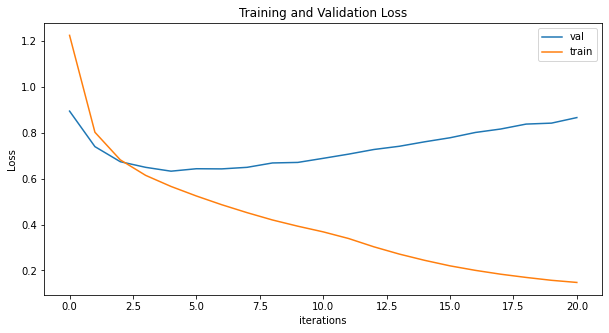

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

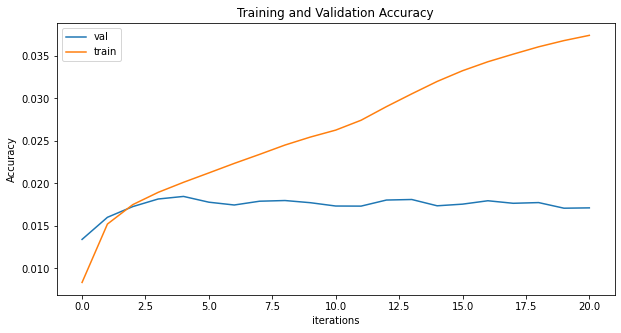

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracies,label="val")
plt.plot(train_accuracies,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def evaluate(image):
   temp_input = tf.expand_dims(decode_and_resize(image), 0)
   img_tensor_val = cnn_model(temp_input)
  #  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   start_token = word_to_index(tf.constant('<start>'))
   end_token = word_to_index(tf.constant('<end>'))
   decoder_input = [start_token]
   output = tf.expand_dims(decoder_input, 0) #tokens
   result = [] #word list

   for i in range(100):
      dec_mask = create_masks_decoder(output)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      # print(predictions.shape)
      # print(output.shape)


      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int64)
      if predicted_id == end_token:
         return result,tf.squeeze(output, axis=0), attention_weights
      result.append(tf.compat.as_text(index_to_word(int(predicted_id.numpy())).numpy()))
      output = tf.concat([output, predicted_id], axis=-1)

   return result,tf.squeeze(output, axis=0), attention_weights

In [ ]:
#  rid = np.random.randint(0, len(test_images))

def test_single_img(id):
  test_images = list(testing_data.keys())
  image = test_images[id]

  captions = testing_data[image]
  bleu_scores = []
  for caption in captions:
    real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in vectorization(caption) if i not in [0]])
    caption,result,attention_weights = evaluate(image)

    first = real_caption.split(' ', 1)[1]
    real_caption = first.rsplit(' ', 1)[0]

    for i in caption:
      if i=="<unk>":
          caption.remove(i)

    for i in real_caption:
      if i=="<unk>":
          real_caption.remove(i)

    result_join = ' '.join(caption)
    result_final = result_join.rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = caption

    # score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
    # print(f"BLEU-1 score: {score*100}")
    # score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
    # print(f"BLEU-2 score: {score*100}")
    # score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
    # print(f"BLEU-3 score: {score*100}")
    score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
    bleu_scores.append(score)
    print(f"BLEU-4 score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Predicted Caption:', ' '.join(caption))
    temp_image = np.array(Image.open(image))
    plt.imshow(temp_image)

  return np.mean(bleu_scores)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-4 score: 26.176079745548464
Real Caption: football players wearing orange uniforms are tackling a player in a white uniform
Predicted Caption: two oklahoma sooner football players talk on the sideline


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-4 score: 57.735026918962575
Real Caption: a tackle in a football game
Predicted Caption: two oklahoma sooner football players talk on the sideline
BLEU-4 score: 0
Real Caption: three footballers in a tackle
Predicted Caption: two oklahoma sooner football players talk on the sideline
BLEU-4 score: 41.36895450425725
Real Caption: three men are involved in a football game are tackling each other
Predicted Caption: two oklahoma sooner football players talk on the sideline
BLEU-4 score: 52.35215949109693
Real Caption: two players take down the player with the ball in a football game
Predicted Caption: two oklahoma sooner football players talk on the sideline


0.35526444131973045

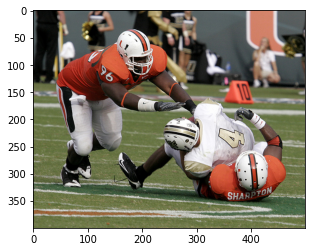

In [ ]:
test_single_img(0)

In [1]:
bleu_scores = []
for i in range(len(testing_data)):
  bleu_score = test_single_img(i)
  bleu_scores.append(bleu_score)

np.mean(bleu_scores)

NameError: name 'testing_data' is not defined

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

73728/64400 [==================================] - 0s 3us/step


ValueError: ignored

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.